In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
import FinanceDataReader as fdr

In [5]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재).
samsung = fdr.DataReader('005930')

In [6]:
# Apple(AAPL), 애플.
apple = fdr.DataReader('AAPL')

In [10]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10241 entries, 1980-12-12 to 2021-07-26
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10241 non-null  float64
 1   Open    10241 non-null  float64
 2   High    10241 non-null  float64
 3   Low     10241 non-null  float64
 4   Volume  10241 non-null  float64
 5   Change  10241 non-null  float64
dtypes: float64(6)
memory usage: 560.1 KB


In [14]:
# date 정보 년 월 일로 분할.
apple['Year'] = apple.index.year
apple['Month'] = apple.index.month
apple['Day'] = apple.index.day
apple["Year"].head()

Date
1980-12-12    1980
1980-12-15    1980
1980-12-16    1980
1980-12-17    1980
1980-12-18    1980
Name: Year, dtype: int64

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


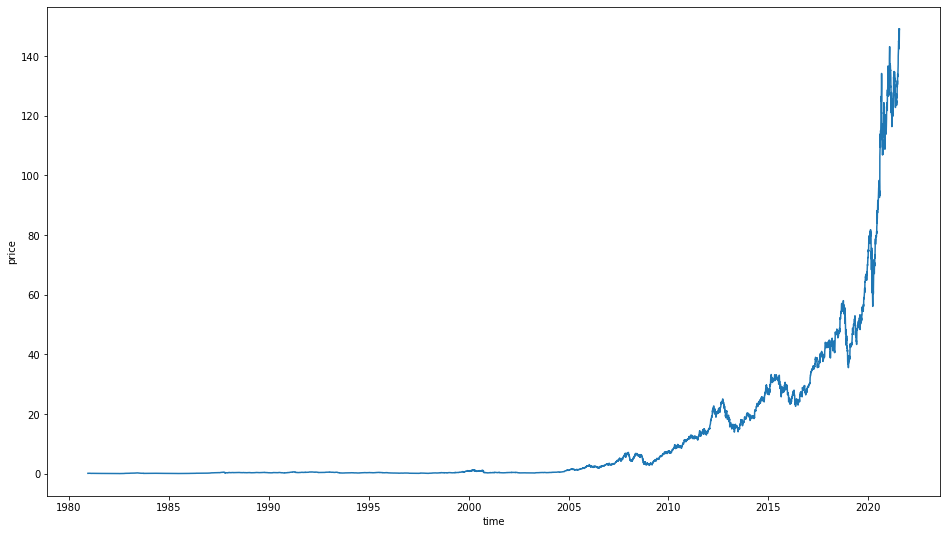

In [15]:
# 시각화.
plt.figure(figsize=(16, 9))
sns.lineplot(y=apple['Close'], x=apple.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


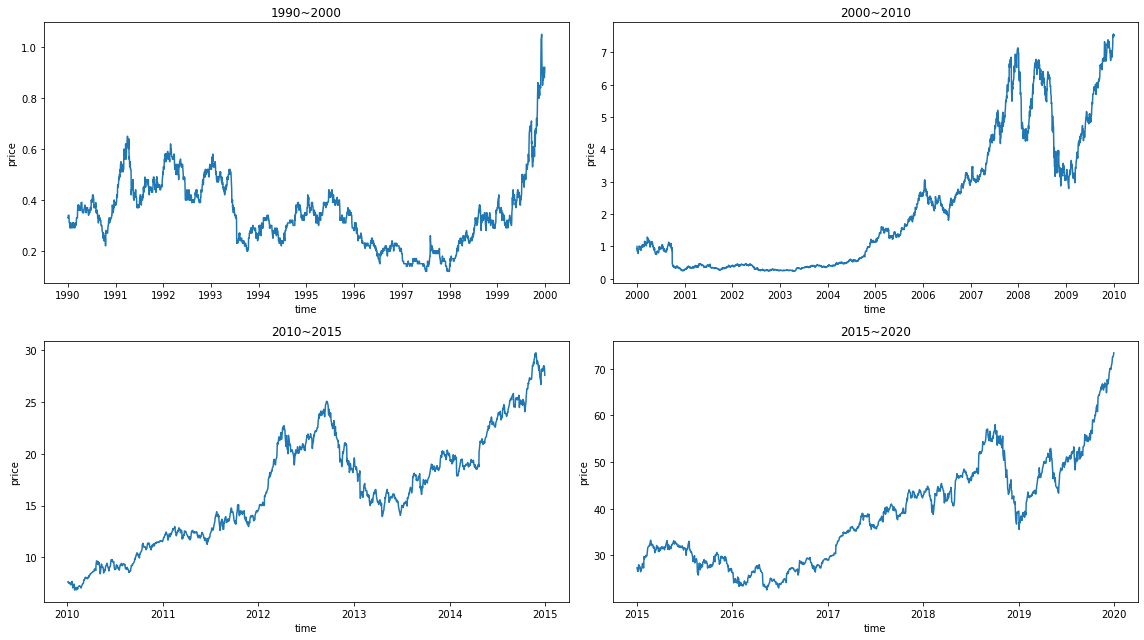

In [17]:
# 시각화2.
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = apple.loc[(apple.index > time_steps[i][0]) & (apple.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [21]:
# 전처리.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 스케일을 적용할 column을 정의.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(apple[scale_cols])
scaled

array([[5.36193029e-04, 5.33582338e-04, 5.41638456e-04, 5.36552649e-04,
        6.29512116e-02],
       [4.69168901e-04, 4.66884546e-04, 4.73933649e-04, 4.69483568e-04,
        2.34889165e-02],
       [4.02144772e-04, 4.00186754e-04, 4.06228842e-04, 4.02414487e-04,
        1.40456963e-02],
       ...,
       [9.77815013e-01, 9.88061095e-01, 9.86865267e-01, 9.84238766e-01,
        1.02239854e-02],
       [9.88605898e-01, 9.91596078e-01, 9.94380501e-01, 9.96042924e-01,
        9.43110488e-03],
       [9.93297587e-01, 9.98932835e-01, 1.00000000e+00, 9.98926895e-01,
        9.56302727e-03]])

In [22]:
# 정규화 된걸 새로 저장.
df = pd.DataFrame(scaled, columns=scale_cols)

In [23]:
# train / test 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [24]:
x_train.shape, y_train.shape

((8192, 4), (8192,))

In [25]:
display(x_train)
display(y_train)

,Open,High,Low,Volume
0,0.000536,0.000534,0.000542,0.062951
1,0.000469,0.000467,0.000474,0.023489
2,0.000402,0.000400,0.000406,0.014046
3,0.000469,0.000467,0.000474,0.011449
4,0.000469,0.000467,0.000474,0.009700
...,...,...,...,...
8187,0.106367,0.107917,0.107177,0.047427
8188,0.107976,0.108517,0.108328,0.051545
8189,0.107574,0.107450,0.106635,0.049937
8190,0.108177,0.107917,0.107854,0.039219


0       0.000537
1       0.000469
2       0.000402
3       0.000469
4       0.000469
          ...   
8187    0.107847
8188    0.107378
8189    0.107646
8190    0.107311
8191    0.106304
Name: Close, Length: 8192, dtype: float64

In [26]:
# TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성
import tensorflow as tf

In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [29]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [30]:
# 데이터셋의 구성 확인.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [31]:
# 모델 구축
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [32]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber() 사용.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [33]:
# earlystopping은 10번의 epoch통안 val_loss 개선이 없으면 학습을 멈춤.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터 생성.
# filename = os.path.join('tmp', 'ckeckpointer.ckpt')
# checkpoint = ModelCheckpoint(filename, 
#                              save_weights_only=True, 
#                              save_best_only=True, 
#                              monitor='val_loss', 
#                              verbose=1)

In [35]:
# 실제 학습.
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[earlystopping])

Epoch 1/50
256/256 [==============================] - 6s 24ms/step - loss: 2.6545e-06 - mse: 5.2747e-06 - val_loss: 0.0094 - val_mse: 0.0170
Epoch 2/50
256/256 [==============================] - 2s 6ms/step - loss: 1.5584e-06 - mse: 3.0848e-06 - val_loss: 0.0088 - val_mse: 0.0159
Epoch 3/50
256/256 [==============================] - 2s 6ms/step - loss: 1.3769e-06 - mse: 2.7362e-06 - val_loss: 0.0082 - val_mse: 0.0149
Epoch 4/50
256/256 [==============================] - 2s 6ms/step - loss: 1.3394e-06 - mse: 2.6517e-06 - val_loss: 0.0079 - val_mse: 0.0143
Epoch 5/50
256/256 [==============================] - 2s 6ms/step - loss: 1.4116e-06 - mse: 2.7506e-06 - val_loss: 0.0078 - val_mse: 0.0141
Epoch 6/50
256/256 [==============================] - 2s 6ms/step - loss: 1.3133e-06 - mse: 2.6190e-06 - val_loss: 0.0073 - val_mse: 0.0132
Epoch 7/50
256/256 [==============================] - 2s 6ms/step - loss: 1.2415e-06 - mse: 2.4610e-06 - val_loss: 0.0070 - val_mse: 0.0127
Epoch 8/50
256/256 

In [36]:
# 모델 예측.
pred = model.predict(test_data)

In [37]:
pred.shape

(2029, 1)

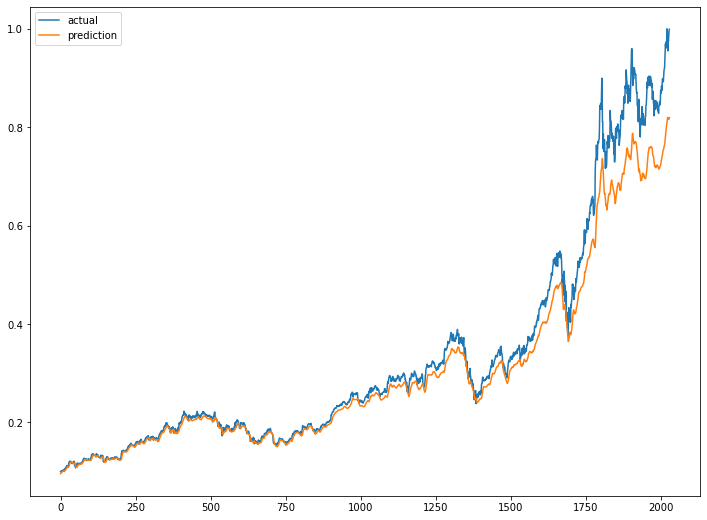

In [38]:
# 예측 데이터 시각화.
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()